In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv("titanic.csv", usecols=["age", "fare", "survived"])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[["age", "fare"]],
    data["survived"],
    test_size=0.3,
    random_state=0
)

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [4]:
def impute_na(data, variable):
    df = data.copy()
    df[variable + "_random"] = df[variable]
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0
    )
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + "_random"] = random_sample
    
    return df[variable + "_random"]

X_train["age"] = impute_na(data, "age")
X_test["age"] = impute_na(data, "age")

X_train["fare"] = impute_na(data, "fare")
X_test["fare"] = impute_na(data, "fare")

In [5]:
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train["age"].to_frame(), y_train)

X_train["Age_tree"] = tree_model.predict_proba(X_train["age"].to_frame())[:, 1]
X_train.head(10)

,age,fare,Age_tree
501,13.0,19.5000,0.366059
588,4.0,23.0000,0.529412
402,30.0,13.8583,0.366059
1193,21.0,7.7250,0.366059
686,22.0,7.7250,0.366059
971,16.0,7.8792,0.366059
117,30.0,56.9292,0.366059
540,2.0,26.0000,0.529412
294,49.0,110.8833,0.450704
261,35.0,26.2875,0.366059


In [7]:
X_train["Age_tree"].unique()

array([0.36605891, 0.52941176, 0.45070423, 0.        , 1.        ])

Text(0, 0.5, 'Survived')

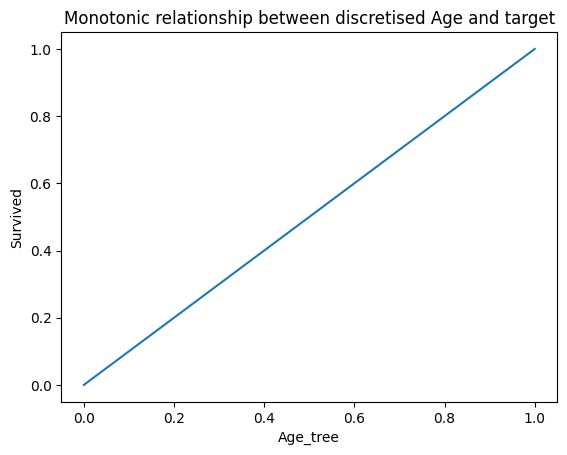

In [8]:
pd.concat([X_train, y_train], axis=1).groupby(["Age_tree"])["survived"].mean().plot()
plt.title("Monotonic relationship between discretised Age and target")
plt.ylabel("Survived")

In [9]:
pd.concat([X_train.groupby(["Age_tree"])["age"].min(),
           X_train.groupby(["Age_tree"])["age"].max()], axis=1)

,age,age
Age_tree,,
0.000000,65.0000,74.0000
0.366059,9.0000,44.0000
0.450704,45.0000,64.0000
0.529412,0.7500,8.0000
1.000000,0.1667,0.1667


Text(0, 0.5, 'Survived')

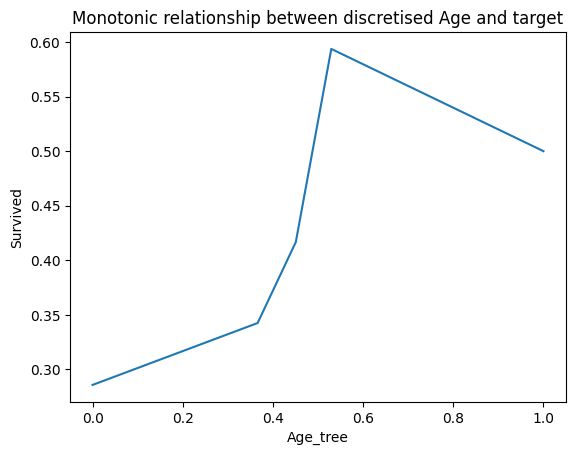

In [10]:
# Notice that this particular tree overfits the training set because
# it doesn't create monotonic relationship between the var and target variable for the test set

X_test["Age_tree"] = tree_model.predict_proba(X_test["age"].to_frame())[:, 1]

pd.concat([X_test, y_test], axis=1).groupby(["Age_tree"])["survived"].mean().plot()
plt.title("Monotonic relationship between discretised Age and target")
plt.ylabel("Survived")

In [14]:
# Build trees with different depths, and calculate the roc-auc of each tree
# choose the depth that generates the best roc-auc

score_ls = []
score_std_ls = []

for tree_depth in [1, 2, 3, 4]:
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)
    scores = cross_val_score(tree_model, X_train["age"].to_frame(), y_train, cv=3, scoring="roc_auc")
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
temp.columns = ["depth", "roc_auc_mean", "roc_auc_std"]
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.501610,0.010728
1,2,0.526407,0.018134
2,3,0.515982,0.029126
3,4,0.527269,0.024281


In [15]:
tree_model = DecisionTreeClassifier(max_depth=2)
tree_model.fit(X_train["age"].to_frame(), y_train)

X_train["Age_tree"] = tree_model.predict_proba(X_train["age"].to_frame())[:, 1]
X_test["Age_tree"] = tree_model.predict_proba(X_test["age"].to_frame())[:, 1]

Text(0, 0.5, 'Survived')

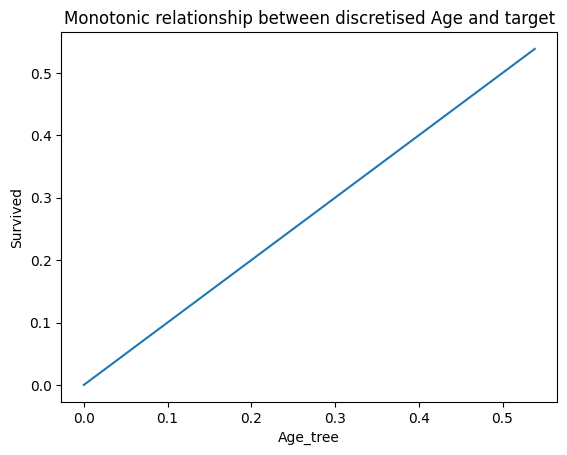

In [16]:
pd.concat([X_train, y_train], axis=1).groupby(["Age_tree"])["survived"].mean().plot()
plt.title("Monotonic relationship between discretised Age and target")
plt.ylabel("Survived")

Text(0, 0.5, 'Survived')

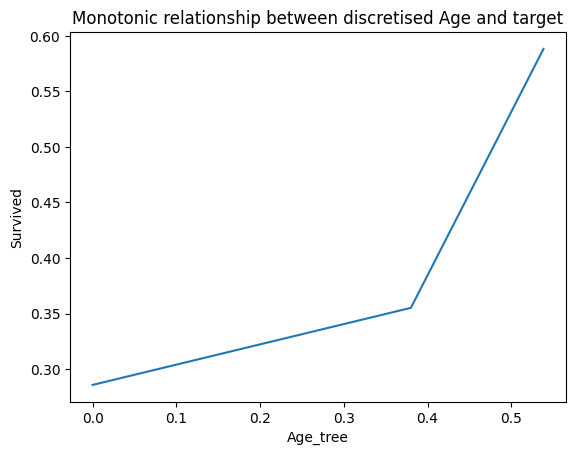

In [17]:
X_test["Age_tree"] = tree_model.predict_proba(X_test["age"].to_frame())[:, 1]

pd.concat([X_test, y_test], axis=1).groupby(["Age_tree"])["survived"].mean().plot()
plt.title("Monotonic relationship between discretised Age and target")
plt.ylabel("Survived")